# Locate and link notebook for vibration thin layer experiment

## A) Locate 
1) Import and read the .cine movie file from the experiment.

2) Create circular masks to focus only on the circular vibrating platform.

3) Apply the mask to the frames of the clip.

4) Locate all the features (particules) and create a DataFrame with x,y positions for each frame.

5) Save the DataFrame into a pickle file.



### Import the required libraries

In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  
import pims
import trackpy as tp
from scipy.signal import savgol_filter

#interactive graphics
%matplotlib widget 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

### Create circular masks to focus only on the circular vibrating platform

In [2]:
def createCircularMask(h, w, center=None, radius=None):
    """
    Creates an OpenCV circular mask
        
    Parameters
    ----------
    h : int
    Height of the image for which the mask is going to be used
    w : int
    Width of the image for which the mask is going to be used
    center : tuple or list, optional
    Pair of coordinates for the mask's central point. If not specified uses: [w/2, h/2]
    radius : float, optional
    Value of the mask radius. If not specified uses max possible value
    
    Returns
    -------
    mask : array
    Mask for using with the image (array of True/False values)
    """
    
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    mask = dist_from_center <= radius
    
    return mask

@pims.pipeline
def maskImage(img, mask):
    """ 
    Masks an input image
      
    Parameters
    ----------
    img : array
    Input image
    mask : array
    True/False array with same shape as input image 
    
    Returns
    -------
    masked_img : array
    output masked image
        
    """
    masked_img = img.copy()
    masked_img[~mask] = 0
    
    return masked_img

### Import and read the .cine movie file from the experiment

Open the .cine file with PIMS

frames: cine object with all the frames of the movie
w, h define the width and height of the frames

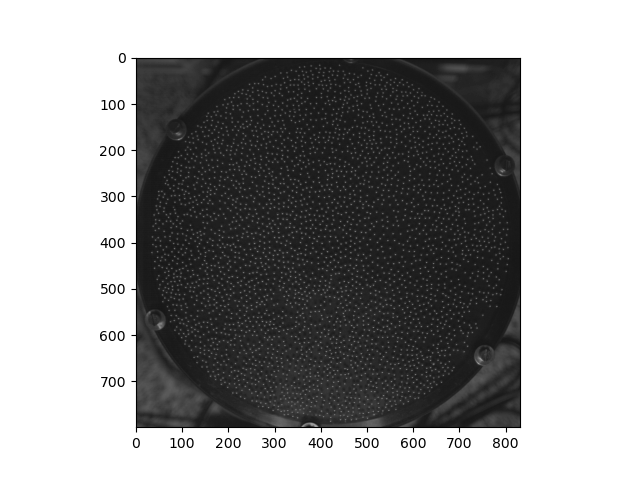

In [3]:
frames=pims.open('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/densidad0.325_f75Hz.cine')
w,h=frames[0].shape


plt.imshow(frames[0],cmap='gray')

### Apply the circular mask to the frames

It is required some try-and-check steps to apply rightly the mask to the circular platform.

PARAMETERS for the mask: 
* w, h
* center of the frame where the circular mask is applied
* radius of the mask

In [4]:
plt.close('all')

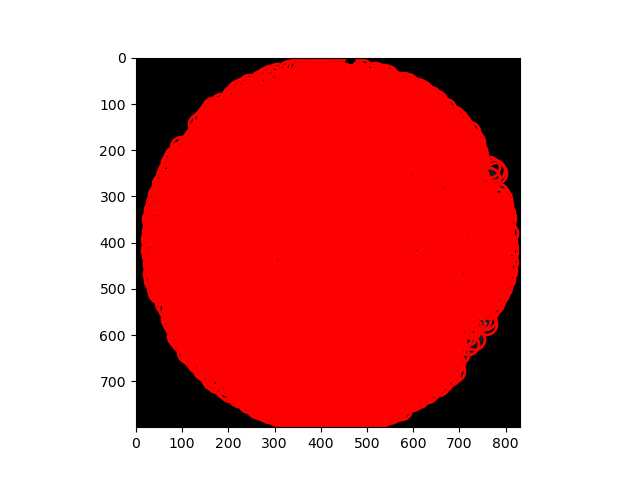

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
7,15.945779,458.962340,132.899631,1.333614,0.618226,18.874709,1337.0,0.156087,10000
10,16.739933,463.104041,129.588813,1.336954,0.671801,20.798784,1401.0,0.147379,10000
11,16.862972,467.977897,127.709320,1.311940,0.576072,18.809009,1290.0,0.163167,10000
12,17.797865,386.169052,516.555539,1.127795,0.251907,102.593099,3556.0,0.051199,10000
15,19.052376,366.123466,577.379780,1.118400,0.301839,112.072689,3588.0,0.050707,10000
...,...,...,...,...,...,...,...,...,...
6045,789.325136,400.984676,191.396210,1.345923,0.656042,28.448156,2010.0,0.096270,10000
6046,789.204843,410.030536,197.560290,1.361096,0.645762,28.551399,2155.0,0.088928,10000
6047,789.348866,424.081572,164.508432,1.318348,0.584715,26.486538,2121.0,0.090547,10000
6048,789.327782,436.042424,183.458227,1.358552,0.650300,26.287091,2000.0,0.096822,10000


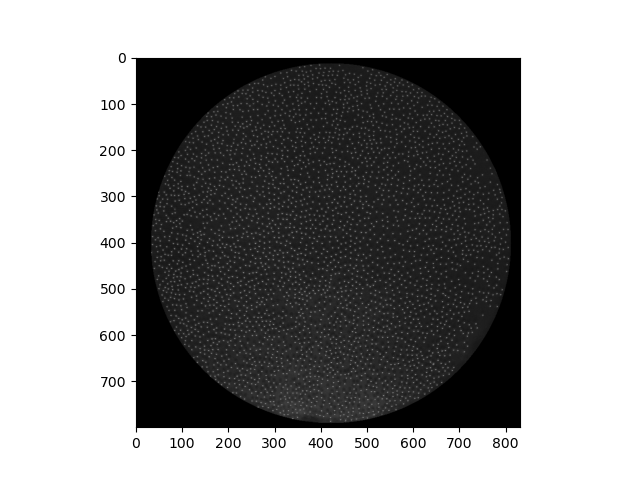

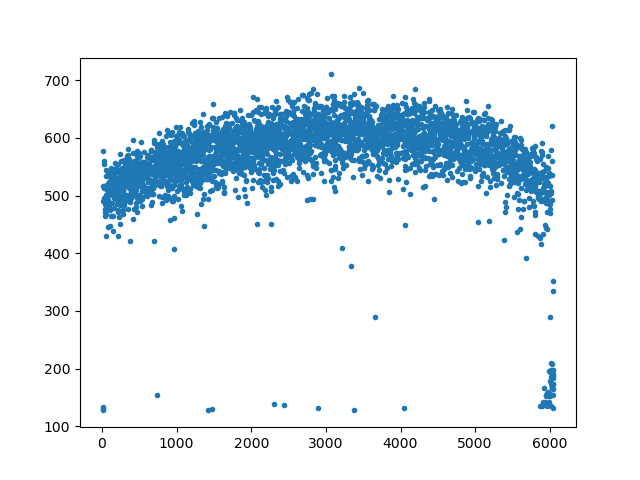

In [4]:
mascara=createCircularMask(w,h,center=(421,402),radius=389);
imagen=maskImage(frames, mascara);
plt.figure()
plt.imshow(imagen[10],cmap='gray')
f=tp.locate(imagen[10000],5,minmass=125,separation=4)
plt.figure()
tp.annotate(f,imagen[10000])
plt.figure()
plt.plot(f['mass'],'.')
f

### Locate the features in each frame

Features in each frame are the particles. Every particle have a unique (x,y) position for each frame (time instant).

The trackpy library is used to locate the particles. A for-loop is used to apply locate function for the whole frame banch.

A DataFrame is generated with columns=('x','y','frame').

PARAMETERS required: trackpy.locate(frame[i],size,minmass,separation)

* individual frame (frame[i])
* feature diamater size in pixels
* minimum mass of the features
* minimum separation in pixels

In [5]:
df=pd.DataFrame()
for i in range(frames.shape[0]):
   if i==0:
       f=tp.locate(imagen[i],5,minmass=125,separation=4)
       f=f[['x','y','frame']]
       df=pd.concat([df,f], ignore_index=True)
       
       #f.to_csv('dataloc_120Hz_150us_75.csv',mode='a',index=False,header=True,columns=('x','y','frame'))
   else:
       leng=f.shape[0]
       f=tp.locate(imagen[i],5,minmass=125,separation=4)
       f=f[['x','y','frame']]
       df=pd.concat([df,f], ignore_index=True)
       #f.to_csv('dataloc_120Hz_150us_75.csv',mode='a',index=False,header=False,columns=('x','y','frame'))        
   if i%100==0:
       print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [11]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.375_f75Hz.pkl')
frametime=np.loadtxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/frametime_densidad0.375_f75Hz.txt')

FileNotFoundError: [Errno 2] No such file or directory: '/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.375_f75Hz.pkl'

### Calculate times per frame to obtain velocity afterwards

Function file_cine.frame_time_stamps gives the time for each frame

In [6]:
def to_time(video_obj):
    
    times = np.array(video_obj.frame_time_stamps).T
    t = np.zeros(video_obj.image_count) 
    s = times[0][0].second
    ns = 0
    for i in range(video_obj.image_count):
        if times[0][i].second != s:
            ns = ns + 1
            s = times[0][i].second
        t[i] = times[1][i] + ns

    t = t - times[1][0]
    
    return t

In [7]:
frametime=to_time(frames)

### Save the DataFrame with all the particles located in all frames

A pickle file is used to save the DataFrame to save memory space

In [8]:
df.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.325_f75Hz.pkl')


In [9]:
np.savetxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/frametime_densidad0.325_f75Hz.txt',frametime)

## B) Linking

This part of the notebook link all the particles along the frames and create trajectories for each particle.

1) Load DataFrame with the particle (x,y) location for each frame.

2) Calculate the number of frames of the movie.

3) Define the size of the sub DF to link the particles (this should save RAM and make the process quicker).

4) Apply link function from trackpy.

5) Save the Dataframe with trajectories for each particle along the frames.


### Load DataFrame from location
If these linking cells will be run without running locate cells, the dataframe of the location have to be loaded and create a dataframe variable

In [2]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Kovacs/locate_120Hz_densidad0.5_stepdown_62.5_25.pkl')

### Previous calculations

* Extract the number of frames
* Define the size of the sub-DF to link particles

### Apply link function from trackpy

tp.link (df,range, memory)

Tengo que renunciar a hacer el linkado por bloques ya que se generan errores en la trayectoria y el códgio intercambia posiciones de partículas.

In [10]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3385 trajectories present.


In [11]:
linked.particle.nunique()

99182

In [18]:
#esto da problemas con los subloques que se generan
N=24
Nframe=np.max(df.frame.values)

k=round(Nframe/N)
linked=pd.DataFrame()
for i in range(k):
    sub=df[df.frame<(i+1)*N]
    sub=sub[sub.frame>=i*N]
    
    sublinked=tp.link(sub,4)
    linked=pd.concat([linked,sublinked],ignore_index=True)

Frame 36964: 33 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Save the dataframe with trajectories

In [12]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.325_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

In [2]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Kovacs/linked_120Hz_densidad0.5_stepdown_62.5_25.pkl')

In [3]:
df=df.rename(columns={'particle':'track'})

# B.2) Filtering positions via savgol_filter

In [4]:
def printp(string):
    """ Modification of print function to do everything on one line """
    import sys
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()

In [ ]:
window_length=5
new_df = []
for trajectory in set(df.track):
    sub = df[df.track==trajectory]

    if sub.shape[0] <= window_length+1:
        #Para obviar los casos en los que la trayectoria dura menos que la ventana de suavizado
        pass
    else:
        printp(f'Smoothing positions for track: {trajectory : .0f}')
        # Savgol filter
        sub['x'] = savgol_filter(sub['x'], window_length=5, polyorder=3, axis=0)
        sub['y'] = savgol_filter(sub['y'], window_length=5, polyorder=3, axis=0)
        new_df.append(sub)

new_df = pd.concat(new_df, axis=0)
new_df = new_df.reset_index(drop=True)

Smoothing positions for track:  2

/tmp/ipykernel_51753/1791754304.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['x'] = savgol_filter(sub['x'], window_length=5, polyorder=3, axis=0)
/tmp/ipykernel_51753/1791754304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['y'] = savgol_filter(sub['y'], window_length=5, polyorder=3, axis=0)


Smoothing positions for track:  385246

In [ ]:
new_df.to_pickle('/media/juan/DiscoDuro2G/Kovacs/linkedfilter_120Hz_densidad0.5_stepdown_62.5_25.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

In [ ]:
new_df.track.nunique()

### Copio varias veces para ejecutar el código para varias películas (0.00625)

In [6]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.00625_f75Hz.pkl')

In [7]:
linked=tp.link(df,3,memory=5)

Frame 38418: 65 trajectories present.


In [8]:
linked.particle.nunique()

67

In [9]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.00625_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.0125)

In [10]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.0125_f75Hz.pkl')

In [11]:
linked=tp.link(df,3,memory=5)

Frame 37483: 130 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
linked.particle.nunique()

144

In [13]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.0125_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.025)

In [14]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.025_f75Hz.pkl')

In [15]:
linked=tp.link(df,3,memory=5)

Frame 38418: 260 trajectories present.


In [16]:
linked.particle.nunique()

298

In [17]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.025_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.05)

In [18]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.05_f75Hz.pkl')

In [19]:
linked=tp.link(df,3,memory=5)

Frame 38418: 516 trajectories present.


In [20]:
linked.particle.nunique()

529

In [21]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.05_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.075)

In [22]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.075_f75Hz.pkl')

In [23]:
linked=tp.link(df,3,memory=5)

Frame 38418: 773 trajectories present.


In [24]:
linked.particle.nunique()

1086

In [25]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.075_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.1)

In [26]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.1_f75Hz.pkl')

In [27]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1033 trajectories present.


In [28]:
linked.particle.nunique()

1211

In [29]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.1_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.125)

In [30]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.125_f75Hz.pkl')

In [31]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1291 trajectories present.


In [32]:
linked.particle.nunique()

1338

In [33]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.125_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.15)

In [3]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.15_f75Hz.pkl')

In [11]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1549 trajectories present.


In [12]:
linked.particle.nunique()

1726

In [13]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.15_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.175)

In [38]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.175_f75Hz.pkl')

In [20]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1806 trajectories present.


In [21]:
linked.particle.nunique()

2271

In [22]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.175_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.2)

In [42]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.2_f75Hz.pkl')

In [43]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2065 trajectories present.


In [44]:
linked.particle.nunique()

2658

In [45]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.2_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.225) ya está hecho

### Copio varias veces para ejecutar el código para varias películas (0.25)

In [46]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.25_f75Hz.pkl')

In [47]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2580 trajectories present.


In [48]:
linked.particle.nunique()

3500

In [49]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.25_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

# Por si a caso para densidades>0.25 hay problemas de memoria y se cae el kernel, voy a ejecutarlo para la otra frecuencia f=50 Hz

### Copio varias veces para ejecutar el código para varias películas (0.003125)

In [50]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.003125_f50Hz.pkl')

In [51]:
linked=tp.link(df,3,memory=5)

Frame 38418: 34 trajectories present.


In [52]:
linked.particle.nunique()

133

In [53]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.003125_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.00625)

In [54]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.00625_f50Hz.pkl')

In [55]:
linked=tp.link(df,3,memory=5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
linked.particle.nunique()

91

In [57]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.00625_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.0125)

In [58]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.0125_f50Hz.pkl')

In [59]:
linked=tp.link(df,3,memory=5)

Frame 37833: 130 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
linked.particle.nunique()

156

In [61]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.0125_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.025)

In [62]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.025_f50Hz.pkl')

In [63]:
linked=tp.link(df,3,memory=5)

Frame 38338: 259 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
linked.particle.nunique()

4274

In [65]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.025_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.05)

In [66]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.05_f50Hz.pkl')

In [67]:
linked=tp.link(df,3,memory=5)

Frame 38418: 516 trajectories present.


In [68]:
linked.particle.nunique()

932

In [69]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.05_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.075)

In [70]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.075_f50Hz.pkl')

In [71]:
linked=tp.link(df,3,memory=5)

Frame 38418: 774 trajectories present.


In [72]:
linked.particle.nunique()

1002

In [73]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.075_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.1)

In [74]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.1_f50Hz.pkl')

In [75]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1033 trajectories present.


In [76]:
linked.particle.nunique()

1214

In [77]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.1_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.125)

In [78]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.125_f50Hz.pkl')

In [79]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1291 trajectories present.


In [80]:
linked.particle.nunique()

1916

In [81]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.125_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.15)

In [ ]:
frames=pims.open('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/densidad0.15_f50Hz.cine')
w,h=frames[0].shape

mascara=createCircularMask(w,h,center=(419,402),radius=389);
imagen=maskImage(frames, mascara);

df=pd.DataFrame()
for i in range(frames.shape[0]):
   if i==0:
       f=tp.locate(imagen[i],5,minmass=300,separation=4)
       f=f[['x','y','frame']]
       df=pd.concat([df,f], ignore_index=True)
       
       #f.to_csv('dataloc_120Hz_150us_75.csv',mode='a',index=False,header=True,columns=('x','y','frame'))
   else:
       leng=f.shape[0]
       f=tp.locate(imagen[i],5,minmass=300,separation=4)
       f=f[['x','y','frame']]
       df=pd.concat([df,f], ignore_index=True)
       #f.to_csv('dataloc_120Hz_150us_75.csv',mode='a',index=False,header=False,columns=('x','y','frame'))        
   if i%100==0:
       print(i)
        

       

In [ ]:
frametime=to_time(frames)

In [ ]:
df.to_pickle('/home/juan/OneDrive/Investigación 2022_Física/Laboratorio/locate_densidad0.15_f50Hz.pkl')
np.savetxt('/home/juan/OneDrive/Investigación 2022_Física/Laboratorio/frametime_densidad0.15_f50Hz.txt',frametime)

In [7]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.15_f50Hz.pkl')

In [8]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1549 trajectories present.


In [9]:
linked.particle.nunique()

1791

In [10]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.15_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.175)

In [86]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.175_f50Hz.pkl')

In [30]:
linked=tp.link(df,3,memory=5)

Frame 38418: 1806 trajectories present.


In [31]:
linked.particle.nunique()

3156

In [32]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.175_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.2)

In [90]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.2_f50Hz.pkl')

In [91]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2065 trajectories present.


In [92]:
linked.particle.nunique()

2921

In [93]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.2_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.225) 

In [94]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.225_f50Hz.pkl')

In [95]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2323 trajectories present.


In [96]:
linked.particle.nunique()

3556

In [97]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.225_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.25)

In [98]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.25_f50Hz.pkl')

In [99]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2581 trajectories present.


In [100]:
linked.particle.nunique()

3973

In [101]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.25_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

# A partir de aquí, dejo los cálculos para las densidades>0.25

### Copio varias veces para ejecutar el código para varias películas (0.275)

In [102]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.275_f75Hz.pkl')

In [103]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2838 trajectories present.


In [104]:
linked.particle.nunique()

5617

In [105]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.275_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.3)

In [106]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.3_f75Hz.pkl')

In [107]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3095 trajectories present.


In [108]:
linked.particle.nunique()

6811

In [109]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.3_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.325)

In [2]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.325_f75Hz.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.325_f75Hz.pkl'

In [114]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3606 trajectories present.


In [115]:
linked.particle.nunique()

12157

In [116]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.35_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.35)

In [113]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.35_f75Hz.pkl')

In [114]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3606 trajectories present.


In [115]:
linked.particle.nunique()

12157

In [116]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.35_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.4)

In [117]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.4_f75Hz.pkl')

In [118]:
linked=tp.link(df,3,memory=5)

Frame 38418: 4134 trajectories present.


In [119]:
linked.particle.nunique()

42734

In [120]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.4_f75Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

## A parti de aquí, f=50Hz

### Copio varias veces para ejecutar el código para varias películas (0.275)

In [121]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.275_f50Hz.pkl')

In [122]:
linked=tp.link(df,3,memory=5)

Frame 38418: 2835 trajectories present.


In [123]:
linked.particle.nunique()

7599

In [124]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.275_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.3)

In [125]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.3_f50Hz.pkl')

In [126]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3117 trajectories present.


In [127]:
linked.particle.nunique()

25554

In [128]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.3_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.35)

In [129]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.35_f50Hz.pkl')

In [130]:
linked=tp.link(df,3,memory=5)

Frame 38418: 3624 trajectories present.


In [131]:
linked.particle.nunique()

32961

In [132]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.35_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.4)

In [133]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.4_f50Hz.pkl')

In [134]:
linked=tp.link(df,3,memory=5)

Frame 38418: 4131 trajectories present.


In [135]:
linked.particle.nunique()

40542

In [136]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.4_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')

### Copio varias veces para ejecutar el código para varias películas (0.175)

In [133]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/locate_densidad0.4_f50Hz.pkl')

In [134]:
linked=tp.link(df,3,memory=5)

Frame 38418: 4131 trajectories present.


In [135]:
linked.particle.nunique()

40542

In [136]:
linked.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.4_f50Hz.pkl')
  
 #   linked.to_pickle(f'datalink_120HZ_150us_{i}.pkl')